### Get data from S3

In [932]:
import pandas as pd
import numpy  as np
import boto3
import os
import re

from io import StringIO

BUCKET_NAME       = 'scraper-batdongsan'
ACCESS_KEY        = os.environ.get('ACCESS_KEY_ID')
ACCESS_SECRET_KEY = os.environ.get('ACCESS_SECRET_KEY')

In [933]:
# Connect client to access all items in bucket
client = boto3.client('s3', aws_access_key_id=ACCESS_KEY, aws_secret_access_key=ACCESS_SECRET_KEY)
objs   = client.list_objects(Bucket=BUCKET_NAME)['Contents']

# Read data
col = {'uid':'object', 
       'prid':'object', 
       'url':'object', 
       'title_raw':'object', 
       'price_raw':'object',
       'area_raw':'object',
       'bedroom_raw':'object', 
       'toilet_raw':'object', 
       'location_raw':'object', 
       'content_raw':'object', 
       'post_date':'object',
       'scrape_timestamp':'object'}

date_cols = ['post_date', 'scrape_timestamp']

data = []
for obj in objs:
    try:
        csv_obj = client.get_object(Bucket=BUCKET_NAME, Key=obj['Key'])
        body = csv_obj['Body'].read().decode('utf-8')
        temp = pd.read_csv(StringIO(body), header=0, sep=',', dtype=col, parse_dates=date_cols) 
        data.append(temp)
    except:
        print("Reading {} failed".format(obj['Key']))

In [934]:
# Merge
df = pd.concat(data)
df.head(3)

,uid,prid,url,title_raw,price_raw,area_raw,bedroom_raw,toilet_raw,location_raw,content_raw,post_date,scrape_timestamp
0,505160,29056483,https://batdongsan.com.vn/nha-dat-ban-ha-noi/p2,BT 200 - 400m2 The Phoenix Garden LH: 0918756788,Giá thỏa thuận,200 m²,NaN,NaN,"Đan Phượng, Hà Nội",\n TÃ´i cÃ³ cÄn 20...,2021-04-14,2021-04-15 03:10:18.599043
1,1533707,29134056,https://batdongsan.com.vn/nha-dat-ban-ha-noi/p2,Chính chủ bán biệt thự Pháp cổ full nội thất K...,27 tỷ,99 m²,NaN,NaN,"Hoàn Kiếm, Hà Nội",\n NhÃ sá» 8 phá»...,2021-04-14,2021-04-15 03:10:18.599043
2,1498902,29462008,https://batdongsan.com.vn/nha-dat-ban-ha-noi/p2,Nhận đặt chỗ quỹ căn góc đẹp nhất khu C dự án ...,Giá thỏa thuận,300 m²,NaN,NaN,"Thạch Thất, Hà Nội",\n Quá»¹ cÄn gÃ³c ...,2021-04-14,2021-04-15 03:10:18.599043


### Extract more info

In [935]:
def convertPrice(price, area):
    '''Convert price format'''
    try:
        price=str(price); area=str(area)
        if price == "Giá thỏa thuận":
            return None
        elif price.split(" ")[1]=="nghìn/m²":
                return float(re.match("(.*?) nghìn/m²", price).group(1))*float(re.match("(.*?) m²", area).group(1))*1000
        elif price.split(" ")[1]=="triệu/m²":
                return float(re.match("(.*?) triệu/m²", price).group(1))*float(re.match("(.*?) m²", area).group(1))*1000000
        elif price.split(" ")[1]=="tỷ/m²":
                return float(re.match("(.*?) tỷ/m²", price).group(1))*float(re.match("(.*?) m²", area).group(1))*1000000000
        elif price.split(" ")[1]=="nghìn":
            return float(re.match("(.*?) nghìn", price).group(1))*1000
        elif price.split(" ")[1]=="triệu":
            return float(re.match("(.*?) triệu", price).group(1))*1000000
        elif price.split(" ")[1]=="tỷ":
            return float(re.match("(.*?) tỷ", price).group(1))*1000000000
        else:
            return price #this or None?
    except:
        return None

def getArea(area):
    '''Get area as float'''
    try: return float(re.match("(.*?) m²", str(area)).group(1))
    except: return None
    
def getBed(bed):
    '''Get bedroom as float'''
    try: return float(re.match("(.*?) PN", str(bed)).group(1))
    except: return None
    
def getBath(bath):
    '''Get bathroom as float'''
    try: return float(re.match("(.*?) WC", str(bath)).group(1))
    except: return None

In [936]:
# Location
df['district']  = df.apply(lambda x: x['location_raw'].split(", ")[0], axis=1)
df['city']      = df.apply(lambda x: x['location_raw'].split(", ")[1], axis=1)

# Size
df['area_m2'] = df.apply(lambda x: getArea(x['area_raw']), axis=1)
df['bed']     = df.apply(lambda x: getBed(x['bedroom_raw']), axis=1)
df['bath']    = df.apply(lambda x: getBath(x['toilet_raw']), axis=1)

# Days since posted
df['days_since_posted'] = (df['scrape_timestamp']-df['post_date']).apply(lambda x: x.days)

# Prices
df['price_vnd']  = df.apply(lambda x: convertPrice(x['price_raw'], x['area_raw']), axis=1)
df['price_usd']  = df['price_vnd']*0.000043 #VND -> USD
df['usd_per_m2'] = df['price_usd']/df['area_m2']

In [937]:
print(df.dtypes)
df.head(3)

uid                          object
prid                         object
url                          object
title_raw                    object
price_raw                    object
area_raw                     object
bedroom_raw                  object
toilet_raw                   object
location_raw                 object
content_raw                  object
post_date            datetime64[ns]
scrape_timestamp     datetime64[ns]
district                     object
city                         object
area_m2                     float64
bed                         float64
bath                        float64
days_since_posted             int64
price_vnd                   float64
price_usd                   float64
usd_per_m2                  float64
dtype: object


,uid,prid,url,title_raw,price_raw,area_raw,bedroom_raw,toilet_raw,location_raw,content_raw,...,scrape_timestamp,district,city,area_m2,bed,bath,days_since_posted,price_vnd,price_usd,usd_per_m2
0,505160,29056483,https://batdongsan.com.vn/nha-dat-ban-ha-noi/p2,BT 200 - 400m2 The Phoenix Garden LH: 0918756788,Giá thỏa thuận,200 m²,NaN,NaN,"Đan Phượng, Hà Nội",\n TÃ´i cÃ³ cÄn 20...,...,2021-04-15 03:10:18.599043,Đan Phượng,Hà Nội,200.0,NaN,NaN,1,NaN,NaN,NaN
1,1533707,29134056,https://batdongsan.com.vn/nha-dat-ban-ha-noi/p2,Chính chủ bán biệt thự Pháp cổ full nội thất K...,27 tỷ,99 m²,NaN,NaN,"Hoàn Kiếm, Hà Nội",\n NhÃ sá» 8 phá»...,...,2021-04-15 03:10:18.599043,Hoàn Kiếm,Hà Nội,99.0,NaN,NaN,1,2.700000e+10,1161000.0,11727.272727
2,1498902,29462008,https://batdongsan.com.vn/nha-dat-ban-ha-noi/p2,Nhận đặt chỗ quỹ căn góc đẹp nhất khu C dự án ...,Giá thỏa thuận,300 m²,NaN,NaN,"Thạch Thất, Hà Nội",\n Quá»¹ cÄn gÃ³c ...,...,2021-04-15 03:10:18.599043,Thạch Thất,Hà Nội,300.0,NaN,NaN,1,NaN,NaN,NaN


In [938]:
df.groupby(['city', 'district'])['prid'].nunique().reset_index(name='unique_listings').sort_values(by=['city', 'unique_listings'],ascending=False)

,city,district,unique_listings
42,Hồ Chí Minh,Quận 2,1221
49,Hồ Chí Minh,Quận 9,1199
47,Hồ Chí Minh,Quận 7,923
50,Hồ Chí Minh,Thủ Đức,884
30,Hồ Chí Minh,Bình Thạnh,602
52,Hồ Chí Minh,Tân Phú,600
51,Hồ Chí Minh,Tân Bình,587
34,Hồ Chí Minh,Gò Vấp,545
41,Hồ Chí Minh,Quận 12,493
36,Hồ Chí Minh,Nhà Bè,469


In [939]:
# remove invalid prices
# df = df[~df['price_vnd'].astype('str').str.contains('/')]

### Price Distribution

It is possible to have same listing for the same scrape since pages get updated in real time.

In [940]:
# Keep first reading for each listing-scrape
data = df.drop_duplicates(subset=['uid', 'prid', 'scrape_timestamp'], keep='first')
print('{} out of {} listings were unique.'.format(data.shape[0], df.shape[0]))

26400 out of 26940 listings were unique.


In [941]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12,9)})
sns.set_theme(style='whitegrid')

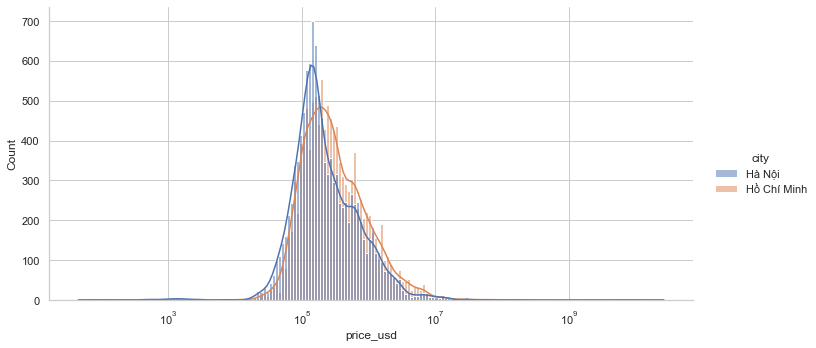

In [942]:
ax = sns.displot(data=data, x='price_usd',  hue='city', log_scale=True, kde=True, aspect=2) #logged

Log(Price) shows rightly skewed distribution, meaning most listings fall below the mean price. There are big estates that are pushing the prices. HCM real estates are more skewed right (more expensive listings with more frequency).

### Prices by District

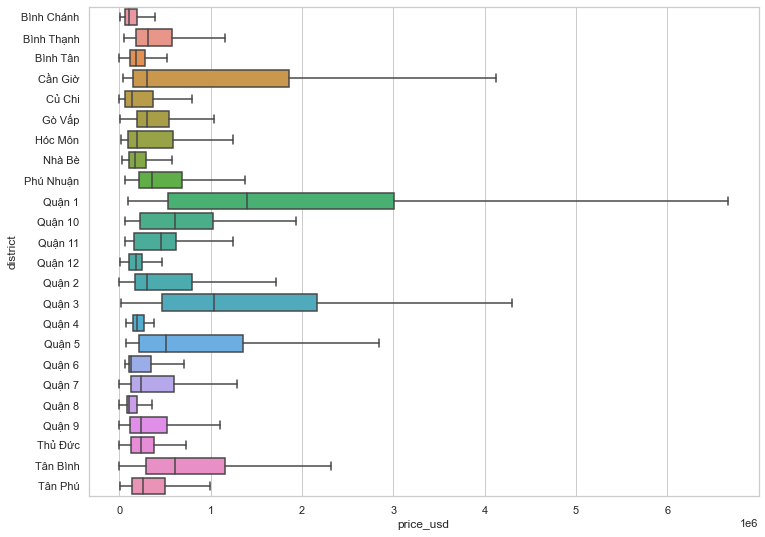

In [943]:
hcm = data[data['city']=='Hồ Chí Minh']

#https://stackoverflow.com/questions/35131798/tweaking-seaborn-boxplot
ax = sns.boxplot(y='district', 
                 x='price_usd',
                 data=hcm, 
                 orient='h',
                 order=sorted(hcm['district'].unique()),
                 showfliers=False)

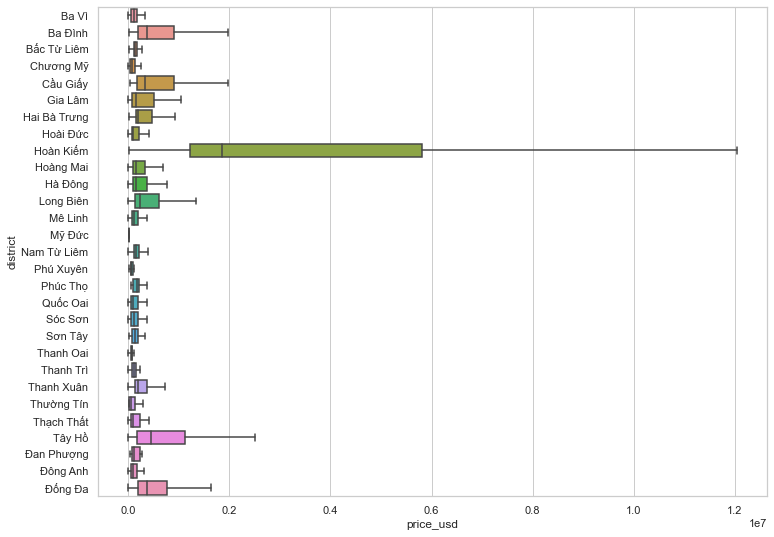

In [944]:
hn = data[data['city']=='Hà Nội']

ax = sns.boxplot(y='district', 
                 x='price_usd',
                 data=hn, 
                 orient='h',
                 order=sorted(hn['district'].unique()),
                 showfliers=False)

### Prices per m2

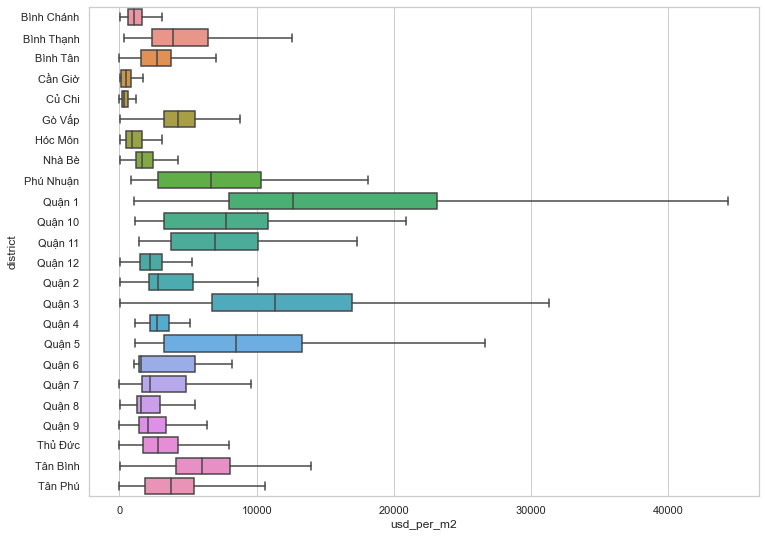

In [945]:
ax = sns.boxplot(y='district', 
                 x='usd_per_m2',
                 data=hcm, 
                 orient='h',
                 order=sorted(hcm['district'].unique()),
                 showfliers=False)

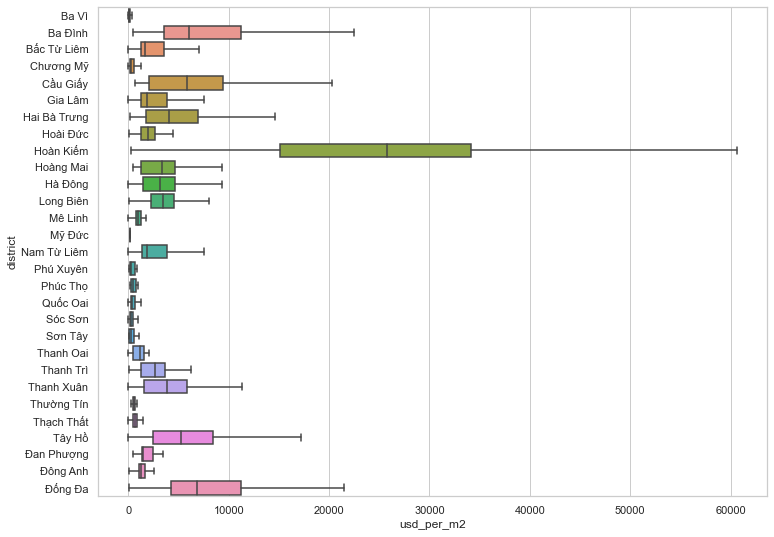

In [946]:
ax = sns.boxplot(y='district', 
                 x='usd_per_m2',
                 data=hn, 
                 orient='h',
                 order=sorted(hn['district'].unique()),
                 showfliers=False)

### Calculate Price Index

In [947]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

reg = LinearRegression()

In [948]:
train_df = hcm.dropna()
train_df.describe()

,area_m2,bed,bath,days_since_posted,price_vnd,price_usd,usd_per_m2
count,1089.000000,1089.000000,1089.000000,1089.000000,1.089000e+03,1.089000e+03,1.089000e+03
mean,109.848356,3.335170,3.188246,3.726354,1.245365e+10,5.355069e+05,7.095534e+03
std,396.738106,2.875905,3.033879,3.253456,1.412181e+11,6.072377e+06,1.164481e+05
min,23.000000,1.000000,1.000000,0.000000,5.000000e+06,2.150000e+02,4.300000e+00
25%,59.000000,2.000000,2.000000,1.000000,2.950000e+09,1.268500e+05,1.737374e+03
50%,74.000000,3.000000,2.000000,3.000000,5.000000e+09,2.150000e+05,2.602632e+03
75%,103.000000,4.000000,4.000000,6.000000,7.900000e+09,3.397000e+05,4.453571e+03
max,12500.000000,42.000000,43.000000,20.000000,4.650000e+12,1.999500e+08,3.845192e+06


In [949]:
continuous  = ['area_m2', 'bed', 'bath', 'days_since_posted']
categorical = ['district']

# Get X
# first, get dummies
dummy_df = pd.get_dummies(train_df[categorical], prefix='', prefix_sep='').drop('Quận 12', 1)
# Quận 12 is our baseline dummy
# keeping index is important in merging categorical dummies back
X = pd.concat([train_df[continuous], dummy_df.set_index(train_df.index)], axis=1) 
print(X.shape[0])

# Get y
y = np.log(train_df['price_usd']) #Logged to conform with normal assumption
print(len(y))

1089
1089


In [950]:
# Split 90:10
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

In [951]:
reg.fit(x_train, y_train)

LinearRegression()

In [952]:
reg.score(x_test, y_test)

0.5588847230523722

Decent accuracy at the moment but could get better with more data.

In [953]:
reg.coef_

array([ 4.73487881e-04,  2.28730242e-02,  8.37406566e-02,  5.76002753e-03,
       -2.52958322e-01,  7.59815732e-01, -9.60025285e-02, -9.79186437e-01,
        6.69144467e-01,  4.61618468e-01, -1.46239594e-01,  7.80413555e-01,
        9.78146479e-01,  7.03558601e-01,  2.49797092e-01,  7.76359247e-01,
        9.26987978e-01,  2.93272281e-01,  2.03031305e-01,  6.33805757e-01,
        3.71423787e-01, -9.13522896e-02,  3.93644946e-01,  6.20757657e-01,
        7.97775121e-01,  6.73188921e-01])

#### Just making sure that coefficients from Statsmodel and Sklearn regressions look the same...

In [954]:
import statsmodels.api as sm

X2 = sm.add_constant(x_train)
est = sm.OLS(y_train,X2).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_usd   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     25.66
Date:                Sun, 18 Apr 2021   Prob (F-statistic):           1.26e-91
Time:                        03:20:14   Log-Likelihood:                -1007.0
No. Observations:                 980   AIC:                             2068.
Df Residuals:                     953   BIC:                             2200.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                11.4825      0.106    108.621      0.000      11.275      11.690
area_m2               0.0005   5.84e-05      8.102      0.000       0.000       0.001
bed                   0.0229      0.031      0.737      0.461      -0.038       0.084
bath                  0.0837      0.029      2.844      0.005       0.026       0.142
days_since_posted     0.0058      0.007      0.839      0.402      -0.008       0.019
Bình Chánh           -0.2530      0.167     -1.510      0.131      -0.582       0.076
Bình Thạnh            0.7598      0.130      5.830      0.000       0.504       1.016
Bình Tân             -0.0960      0.139     -0.689      0.491      -0.370       0.178
Củ Chi               -0.9792      0.355     -2.761      0.006      -1.675      -0.283
Gò Vấp                0.6691      0.133      5.036      0.000       0.408       0.930
Hóc Môn               0.4616      0.323      1.428      0.154      -0.173       1.096
Nhà Bè               -0.1462      0.133     -1.102      0.271      -0.407       0.114
Phú Nhuận             0.7804      0.153      5.112      0.000       0.481       1.080
Quận 1                0.9781      0.171      5.736      0.000       0.643       1.313
Quận 10               0.7036      0.167      4.203      0.000       0.375       1.032
Quận 11               0.2498      0.409      0.611      0.541      -0.552       1.052
Quận 2                0.7764      0.114      6.814      0.000       0.553       1.000
Quận 3                0.9270      0.222      4.179      0.000       0.492       1.362
Quận 4                0.2933      0.229      1.278      0.201      -0.157       0.743
Quận 5                0.2030      0.231      0.879      0.380      -0.250       0.656
Quận 6                0.6338      0.238      2.658      0.008       0.166       1.102
Quận 7                0.3714      0.122      3.050      0.002       0.132       0.610
Quận 8               -0.0914      0.141     -0.650      0.516      -0.367       0.184
Quận 9                0.3936      0.130      3.023      0.003       0.138       0.649
Thủ Đức               0.6208      0.123      5.050      0.000       0.380       0.862
Tân Bình              0.7978      0.167      4.790      0.000       0.471       1.125
Tân Phú               0.6732      0.146      4.618      0.000       0.387       0.959
==============================================================================
Omnibus:                      319.973   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16276.970
Skew:                           0.684   Prob(JB):                         0.00
Kurtosis:                      22.919   Cond. No.                     1.02e+04
==============================================================================

Notes:
[1] Standard Errors a

In [955]:
pd.DataFrame(zip(X.columns, reg.coef_, round(est.pvalues, 2), (np.exp(reg.coef_)-1)*100),
             columns=['var', 'log_lin_coef', 'p_value', 'interpretation'])

,var,log_lin_coef,p_value,interpretation
0,area_m2,0.000473,0.00,0.047360
1,bed,0.022873,0.00,2.313662
2,bath,0.083741,0.46,8.734686
3,days_since_posted,0.005760,0.00,0.577665
4,Bình Chánh,-0.252958,0.40,-22.349976
5,Bình Thạnh,0.759816,0.13,113.788224
6,Bình Tân,-0.096003,0.00,-9.153828
7,Củ Chi,-0.979186,0.49,-62.438344
8,Gò Vấp,0.669144,0.01,95.256612
9,Hóc Môn,0.461618,0.00,58.663983


With Bình Thạnh as the baseline district, keeping all else equal, a listing in in Quận 10 is about 104% more expensive.

### Post Title and Content

In [956]:
import string

from underthesea import classify, word_tokenize
from collections import defaultdict

Try out Underthesea's classification function (their data comes from Baomoi, so topics still limited):

In [957]:
for i in data['title_raw'][:10]:
    print("{}: {}".format(classify(i), i))

['vi_tinh']:  BT 200 - 400m2 The Phoenix Garden LH: 0918756788
['doi_song']: Chính chủ bán biệt thự Pháp cổ full nội thất KD nhà hàng tại số 8 Hạ Hồi, DT 99m2, giá 27 tỷ
['chinh_tri_xa_hoi']: Nhận đặt chỗ quỹ căn góc đẹp nhất khu C dự án Xanh Villas diện tích từ 200m2 đến hơn 1000m2
['chinh_tri_xa_hoi']: Bán nhà La Phù, gần Lê Trọng Tấn, cách Aeonmall Hà Đông 1km, ô tô cách 30m
['chinh_tri_xa_hoi']: Quỹ căn tháng 4/2021 shophouse, biệt thự, liền kề Vinhomes Ocean Park giá rẻ
['chinh_tri_xa_hoi']: Bán biệt thự sân vườn dãy D03 An Vượng Villas, vị trí đẹp nhất dự án, view hồ, 13 tỷ. 0989 69 59 54
['chinh_tri_xa_hoi']: Bảng hàng shophouse liền kề, biệt thự Louis City Hoàng Mai mặt đường Tân Mai vị trí đẹp giá gốc CĐT
['kinh_doanh']: Bán biệt thự Louis City Hoàng Mai, siêu phẩm cho khách đầu tư
['chinh_tri_xa_hoi']: Tổng hợp các căn hộ cần chuyển nhượng giá gốc Vinhomes Ocean Park. Liên hệ 0962432084
['doi_song']: Tây Hồ Residence ngay Hồ Tây ra bảng hàng tầng cao 4 mặt view Hồ giá từ 3,3 

In [958]:
def clean_text(text):
    """Clean text"""
    #To remove the punctuations
    text = text.translate(str.maketrans(' ',' ',string.punctuation))
    # will replace newline with space
    text = re.sub('\n',' ',text)
    # will replace numbers with space
    text = re.sub(' [0-9]+ ',' ',text)
    # will convert to lower case
    text = text.lower()
    # will split and join the words
    text = ' '.join(text.split())
    return text

def get_word_freq(df):
    """Return dict of words and frequency count"""
    word_freq = defaultdict(int) #init dict
    for content in df['content_raw']:
        try:
            text = clean_text(content.encode('latin1').decode('utf8')) #special decode
        except:
            text = clean_text(content) #some raw contents don't need decodes
        for word in word_tokenize(text):
            if word not in stopwords_viet:
                word_freq[word] += 1
    
    return word_freq

In [959]:
# Get stopwords for Vietnamese from https://xltiengviet.fandom.com/wiki/Danh_s%C3%A1ch_stop_word
stopwords_viet = np.loadtxt('stopwords_viet.txt',delimiter='\n',dtype=str)
stopwords_viet

array(['bị', 'bởi', 'cả', 'các', 'cái', 'cần', 'càng', 'chỉ', 'chiếc',
       'cho', 'chứ', 'chưa', 'chuyện', 'có', 'có_thể', 'cứ', 'của',
       'cùng', 'cũng', 'đã', 'đang', 'đây', 'để', 'đến_nỗi', 'đều',
       'điều', 'do', 'đó', 'được', 'dưới', 'gì', 'khi', 'không', 'là',
       'lại', 'lên', 'lúc', 'mà', 'mỗi', 'một_cách', 'này', 'nên', 'nếu',
       'ngay', 'nhiều', 'như', 'nhưng', 'những', 'nơi', 'nữa', 'phải',
       'qua', 'ra', 'rằng', 'rằng', 'rất', 'rất', 'rồi', 'sau', 'sẽ',
       'so', 'sự', 'tại', 'theo', 'thì', 'trên', 'trước', 'từ', 'từng',
       'và', 'vẫn', 'vào', 'vậy', 'vì', 'việc', 'với', 'vừa'], dtype='<U8')

In [960]:
eg = data.iloc[0, 9] #content_raw
print('Raw example of encoded content:\n{}'.format(eg))
print('Decoded:\n{}'.format(eg.encode('latin1').decode('utf8')))
print('Tokenized by Underthesea:\n{}\n'.format(word_tokenize(eg.encode('latin1').decode('utf8'))))
print('Tokenized by Underthesea with clean text:\n{}'.format(word_tokenize(clean_text(eg.encode('latin1').decode('utf8')))))

Raw example of encoded content:

 - Cam káº¿t giÃ¡ bÃ¡n ráº» nháº¥t thá» trÆ°á»...
                        
Decoded:

 - Cam kết giá bán rẻ nhất thị trườ...
                        
Tokenized by Underthesea:
['Tôi', 'có', 'căn', '200', 'm2', 'cần', 'bán', 'gấp', ',', 'hỗ trợ', 'tất cả', 'thuế', 'phí', 'mua bán', '.', '-', 'Diện tích', 'xây', ':', '100', 'm2', 'thiết kế', '3', 'tầng', '+', '1', 'tum', ',', 'mẫu', 'biệt thự', 'song', 'lập', 'mới', '.', '-', 'C6A', '-', '04', 'diện tích', '200', 'm2', ',', 'mặt tiền', '8', 'm', ',', 'hướng', 'Tây Bắc', ',', 'vị trí', 'đẹp', '.', 'Đất', 'đồi', 'cao', ',', 'gần', 'hồ', 'trung tâm', ',', 'gần', '2', 'cổng', 'chính', 'đường', 'Tây', 'thăng long', '.', '-', 'Hỗ trợ', 'vay', 'vốn', 'ngân hàng', 'tới', '80', '%', ',', 'chiết khấu', '8', '%', 'giá trị', 'xây', 'thô', '.', '-', 'Cam kết', 'giá', 'bán', 'rẻ', 'nhất', 'thị', 'trườ', '...']

Tokenized by Underthesea with clean text:
['tôi', 'có', 'căn', '200', 'm2', 'cần', 'bán', 'gấp', 'hỗ trợ', '

In [961]:
hcm_words = get_word_freq(hcm)
hn_words  = get_word_freq(hn)

print("Top HCM Listing Words:\n{}\nTop HN Listing Content:\n{}\n".format(sorted(hcm_words.items(), key=lambda item: item[1], reverse=True)[:10], 
                                                                         sorted(hn_words.items(), key=lambda item: item[1], reverse=True)[:10]))

Top HCM Listing Words:
[('m', 10798), ('nhà', 10675), ('bán', 10655), ('m2', 8618), ('giá', 7351), ('đường', 7314), ('diện tích', 5919), ('quận', 5292), ('tỷ', 5276), ('đất', 4312)]
Top HN Listing Content:
[('nhà', 12579), ('m2', 12402), ('bán', 11071), ('m', 9965), ('tầng', 7212), ('diện tích', 6513), ('chủ', 5350), ('đất', 4900), ('đường', 4846), ('giá', 4836)]



In [962]:
hcm_words_df = pd.DataFrame([[k] + [v] for k, v in hcm_words.items()], 
                   columns=['word', 'freq'])
hn_words_df = pd.DataFrame([[k] + [v] for k, v in hn_words.items()], 
                   columns=['word', 'freq'])

freq_df = pd.merge(left=hcm_words_df, 
                   right=hn_words_df, 
                   how='outer', on='word',suffixes=("_hcm", "_hn"),copy=True)

In [963]:
freq_df.fillna(0)

,word,freq_hcm,freq_hn
0,tọa lạc,317.0,102.0
1,đại lộ,139.0,156.0
2,trần văn giàu,49.0,0.0
3,bình chánh,436.0,0.0
4,nối,73.0,77.0
...,...,...,...
21086,dt36m2,0.0,1.0
21087,kim chỉ,0.0,1.0
21088,bỏngdành,0.0,1.0
21089,ws,0.0,1.0
